# Time Series Regression Analysis

# Importing Necessary Packages

In [2]:
import os
import pyodbc
from dotenv import load_dotenv, dotenv_values, find_dotenv
import pandas as pd

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from itertools import *

## Loading Data From Database

In [5]:
#reading data from database
#Load environment variables from .env file into a dictionary variable
#.env file MUST be in the same root as the notebook to work or alternatively use find_dotenv
environment_variables=dotenv_values(find_dotenv('.env'))
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
 
#Connecting to the database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
 
# Using the connect method of the pyodbc library.
# This will connect to the server.
connection=pyodbc.connect(connection_string)
 
#hide warnings
import warnings
 
warnings.filterwarnings('ignore')
 
print("connected successfully")

connected successfully


#### Adding Connected data to Database folder

In [6]:
#reading data from the remote database table
query='''SELECT *
        FROM dbo.oil'''
       
oil=pd.read_sql(query,connection)
 
oil.to_csv('../Datasets/oil.csv', index=False)

In [7]:
#reading data from the remote database table
query='''SELECT *
        FROM dbo.holidays_events'''
       
holidays=pd.read_sql(query,connection)
 
holidays.to_csv('../Datasets/holidays.csv', index=False)

In [8]:
#reading data from the remote database table
query='''SELECT *
        FROM dbo.stores'''
       
stores=pd.read_sql(query,connection)
 
stores.to_csv('../Datasets/stores.csv', index=False)

### Loading datasets to notebook as dataframes

In [9]:
# Adding all datasets as dataframes 
df_train = pd.read_csv("../Datasets/train.csv")
df_trans = pd.read_csv("../Datasets/transactions.csv")
df_holidays = pd.read_csv("../Datasets/holidays.csv")
df_stores = pd.read_csv("../Datasets/stores.csv")
df_oil = pd.read_csv("../Datasets/oil.csv")

# Data Understanding
Data understanding will follow the following order
1. Check for shape
2. Check for duplicates in data frames
3. Check for nulls in 
4. check data types in the columns
5. Run exploratory data analysis

#### Checking for Dataframe Shapes

In [10]:
data = {'train':df_train,'transactions':df_trans,'oil':df_oil,'stores':df_stores,'holidays':df_holidays}
shape = {}
 
for df in data:
    shape[df] = data[df].shape
   
print(pd.DataFrame(shape).T.rename(columns = {0:'rows',1:'columns'}))

                 rows  columns
train         3000888        6
transactions    83488        3
oil              1218        2
stores             54        5
holidays          350        6


### Checking for Nulls in dataframes

In [11]:
dataframes = {'train':df_train,'transactions':df_trans,'oil':df_oil,'stores':df_stores,'holidays':df_holidays}

def check_nulls(dataframes):
    for name, df in dataframes.items():
        null_count = df.isnull().sum().sum()
        if null_count == 0:
            print(f"No null values found in DataFrame {name}.")
        else:
            print(f"Null values found in DataFrame {name}: {null_count}.")
            
check_nulls(dataframes)


No null values found in DataFrame train.
No null values found in DataFrame transactions.
Null values found in DataFrame oil: 43.
No null values found in DataFrame stores.
No null values found in DataFrame holidays.


In [12]:
# Checking the oil  dataframe with null entries
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

### Checking for duplicates

In [13]:
def check_duplicates(dataframes):
    for name, df in dataframes.items():
        null_count = df.duplicated().sum().sum()
        if null_count == 0:
            print(f"No duplicate values found in DataFrame {name}.")
        else:
            print(f"duplicate values found in DataFrame {name}: {null_count}.")
            
check_duplicates(dataframes)

No duplicate values found in DataFrame train.
No duplicate values found in DataFrame transactions.
No duplicate values found in DataFrame oil.
No duplicate values found in DataFrame stores.
No duplicate values found in DataFrame holidays.


### Checking data frame infos

In [14]:
def check_dataframes_info(dataframes):
    for name, df in dataframes.items():
        print(f"DataFrame Info for {name}:")
        df.info()
        print("=" * 50)
check_dataframes_info(dataframes)

DataFrame Info for train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
DataFrame Info for transactions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
DataFrame Info for oil:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      -

### Checking Dataframe descriptions

In [15]:
def check_dataframes_describe(dataframes):
    for name, df in dataframes.items():
        print(f"DataFrame Info for {name}:")
        dfs_description = df.describe()
        print(dfs_description)
        print("=" * 50)
check_dataframes_describe(dataframes)

DataFrame Info for train:
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
DataFrame Info for transactions:
          store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000
DataFrame Info for oil:
        dcoilwtico
count  1175.000000
mean     67.714

#### **Observation of dataframe Info**
**train DataFrame:**
  - Columns: id, store_nbr, sales, onpromotion
  - Count: 3,000,888 entries
  - Mean sales: 357.7757
  - Std Deviation: 1,101.998
  - Min sales: 0
  - Max sales: 124,717

**transactions DataFrame:**
  - Columns: store_nbr, transactions
  - Count: 83,488 entries
  - Mean transactions: 1,694.6022
  - Std Deviation: 963.2866
  - Min transactions: 5
  - Max transactions: 8,359

**oil DataFrame:**
  - Columns: dcoilwtico
  - Count: 1,175 entries
  - Mean oil price: 67.7144
  - Std Deviation: 25.6305
  - Min oil price: 26.19
  - Max oil price: 110.62

**stores DataFrame:**
  - Columns: store_nbr, cluster
  - Count: 54 entries
  - Mean cluster: 8.4815
  - Std Deviation: 4.6934
  - Min cluster: 1
  - Max cluster: 17

**holidays DataFrame:**
  - Columns: date, type, locale, locale_name, description, transferred
  - Count: 350 entries
  - Unique types: 6
  - Unique locales: 3
  - Most frequent type: Holiday
  - Most frequent locale: Ecuador
  - Most frequent description: Carnaval

### Converting date columns to datetime

In [16]:
#convert date to datetime
for df in dataframes.keys():
    if df != 'stores':
        dataframes[df]['date'] = pd.to_datetime(dataframes[df]['date']) #convert date to datetime
        dataframes[df] = dataframes[df].set_index('date') #set date as index

In [17]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [18]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [19]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [20]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [21]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## **Exploratory Data Anlysis** 

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


#### **Train Data Completeness**  
***Is the train dataset complete (has all the required dates)?***

In [23]:
# Checking for data completeness
start_date = df_train['date'].min()
end_date = df_train['date'].max()
print(f'The data starts on {start_date} and ends on {end_date}, covering a period of {end_date - start_date} hours' )
date_range = pd.date_range(start_date, end_date)
print(f'{date_range}')
missing_days = date_range.difference(df_train['date'])
print(f'These are the missing_days in the data \n {missing_days}')

The data starts on 2013-01-01 00:00:00 and ends on 2017-08-15 00:00:00, covering a period of 1687 days 00:00:00 hours
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')
These are the missing_days in the data 
 DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


***Cleaning for missing dates***

In [24]:
#extracting the store numbers and families
stores = df_train['store_nbr'].unique()
families = df_train['family'].unique()
print(f'There are {stores.size} unique stores and {families.size} unique family groups')
 
#Creating data for the missing days.
missing_data = product(missing_days, stores, families) #use itertools product method to create data for each store and family on each date.
 
#convert to a dataframe and set date as index
missing_df = pd.DataFrame(missing_data, columns=['date','store_nbr','family']).set_index('date')
missing_df.info()
missing_df

There are 54 unique stores and 33 unique family groups
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7128 entries, 2013-12-25 to 2016-12-25
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  7128 non-null   int64 
 1   family     7128 non-null   object
dtypes: int64(1), object(1)
memory usage: 167.1+ KB


,store_nbr,family
date,,
2013-12-25,1,AUTOMOTIVE
2013-12-25,1,BABY CARE
2013-12-25,1,BEAUTY
2013-12-25,1,BEVERAGES
2013-12-25,1,BOOKS
...,...,...
2016-12-25,9,POULTRY
2016-12-25,9,PREPARED FOODS
2016-12-25,9,PRODUCE


In [25]:
# Concatenate missing_df with df_train
df_train = pd.concat([df_train, missing_df])
# Sort the DataFrame by date


In [26]:
df_train = df_train.sort_values('date')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3008016 entries, 0 to 2016-12-25 00:00:00
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           float64       
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 160.6+ MB


In [27]:
df_train = df_train.drop(columns=['id'])

In [28]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1194,2013-01-01,42,CELEBRATION,0.0,0.0
1193,2013-01-01,42,BREAD/BAKERY,0.0,0.0
1192,2013-01-01,42,BOOKS,0.0,0.0
1191,2013-01-01,42,BEVERAGES,0.0,0.0


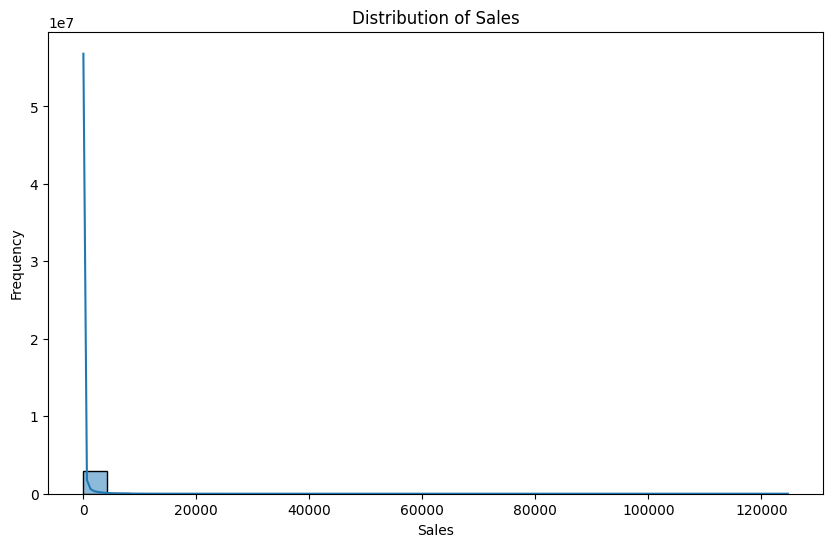

In [29]:
# Distribution of Sales
plt.figure(figsize=(10, 6))
sns.histplot(df_train['sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

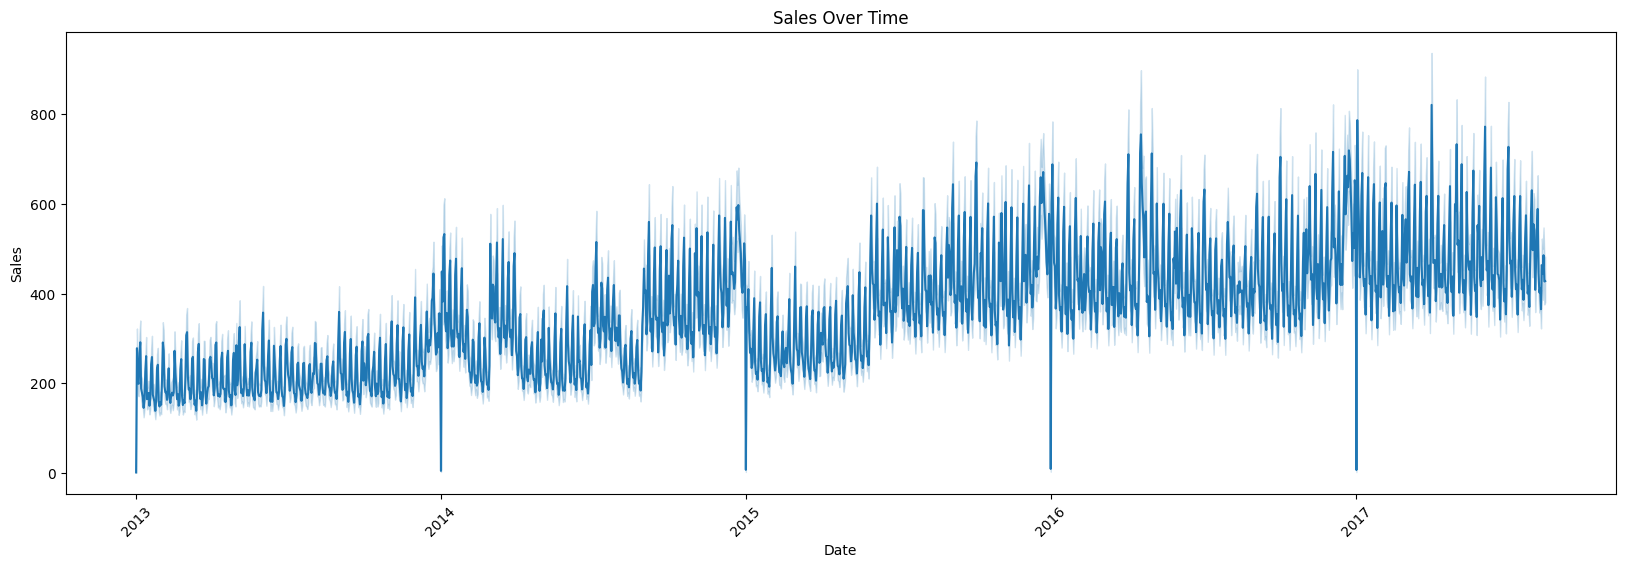

In [30]:
# Sales vs. Date
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_train, x='date', y='sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

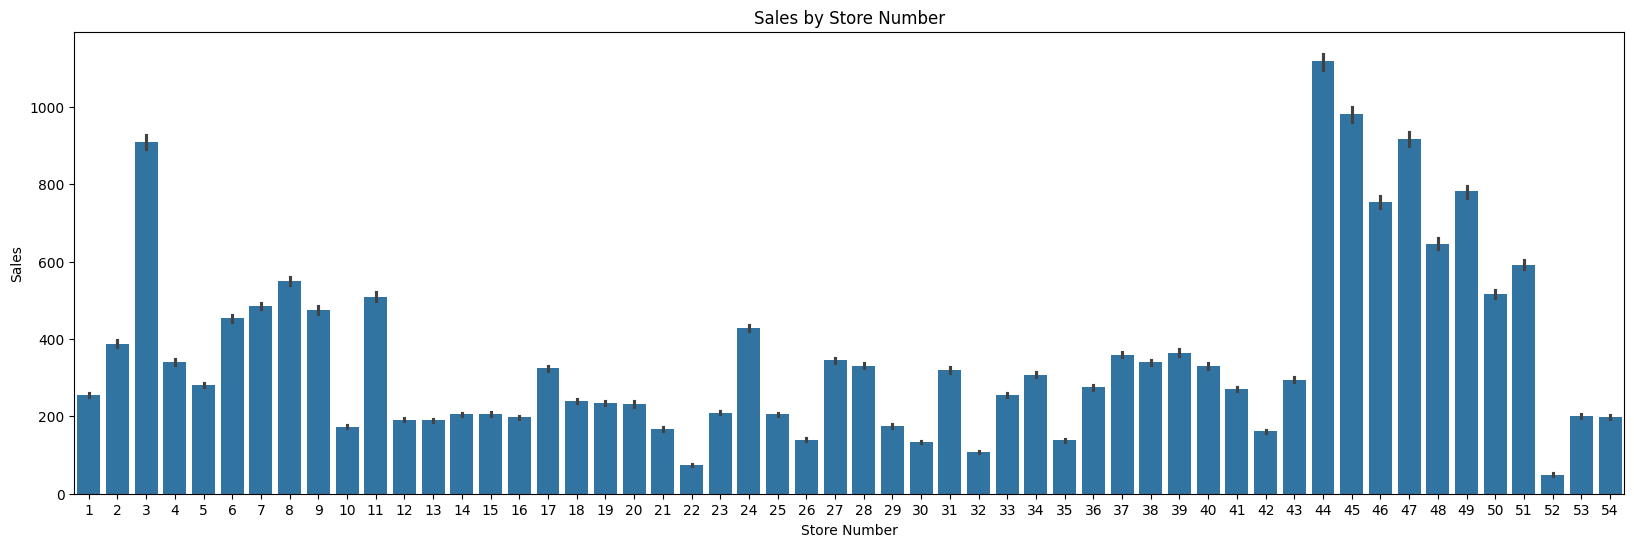

In [31]:
# Sales by Store Number
plt.figure(figsize=(20, 6))
sns.barplot(data=df_train, x='store_nbr', y='sales')
plt.title('Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()

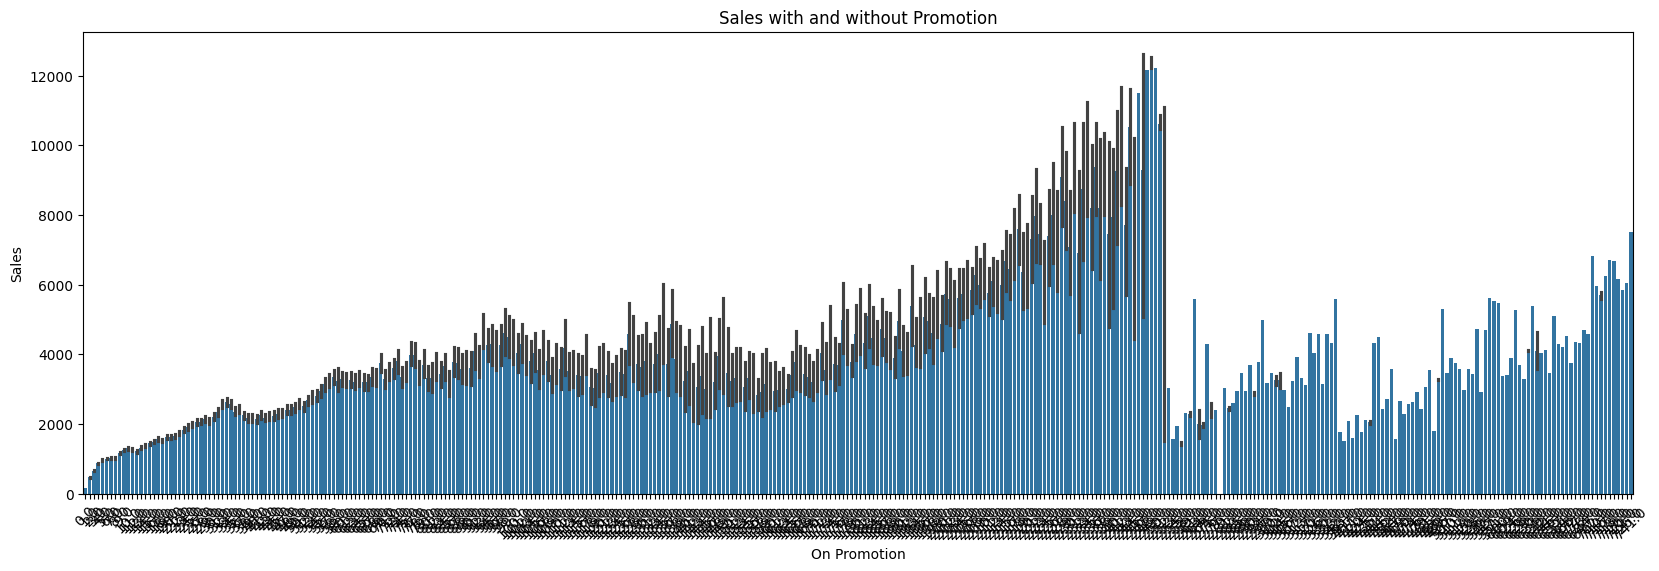

In [32]:
# On Promotion Analysis
plt.figure(figsize=(20, 6))
sns.barplot(data=df_train, x='onpromotion', y='sales')
plt.title('Sales with and without Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()




5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

#### ***Question*** 
**Compare the sales for each month across the years and determine which month of which year had the highest sales.**

In [33]:
# Extract month and year from the 'date' column
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

# Group by month and year, summing the sales
monthly_sales = df_train.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month and year with the highest sales
max_sales_month = monthly_sales.loc[monthly_sales['sales'].idxmax()]
print("Month and Year with the Highest Sales:")
print(max_sales_month)

Month and Year with the Highest Sales:
year     2.016000e+03
month    1.200000e+01
sales    2.964029e+07
Name: 47, dtype: float64


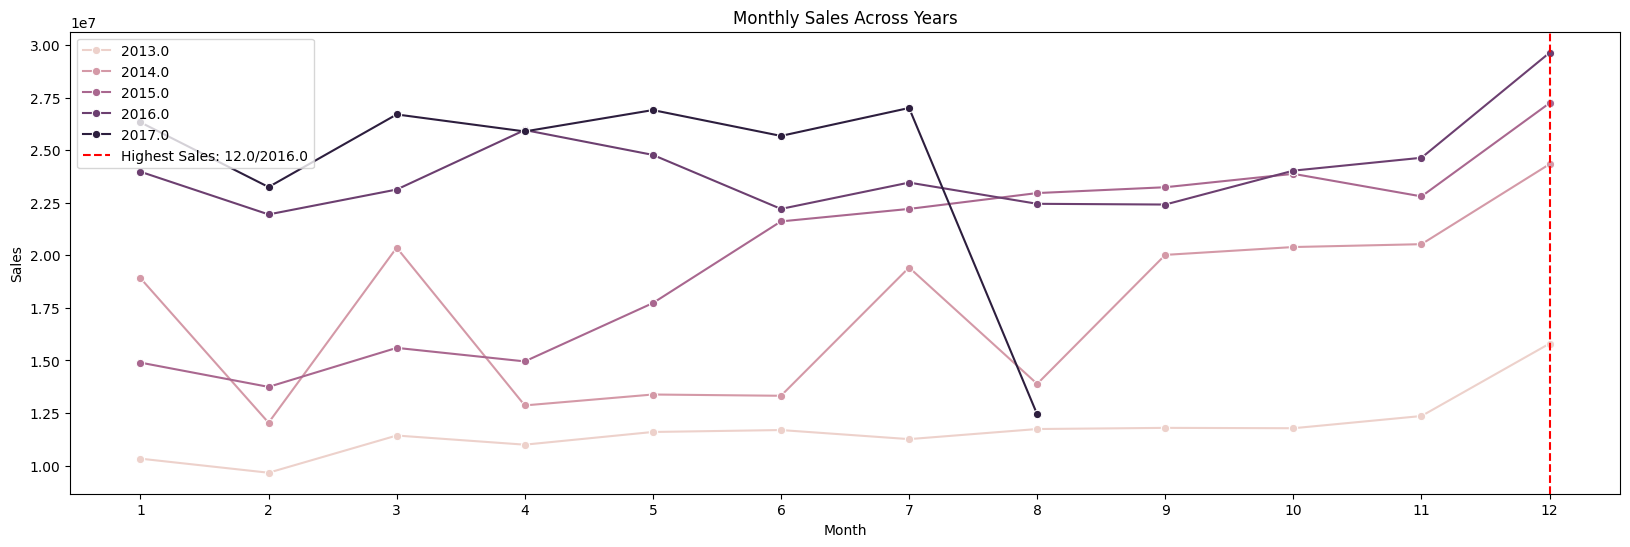

In [34]:
# Plotting
plt.figure(figsize=(20, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', marker='o')
plt.title('Monthly Sales Across Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.axvline(x=max_sales_month['month'], color='r', linestyle='--', label=f'Highest Sales: {max_sales_month["month"]}/{max_sales_month["year"]}')
plt.legend()
plt.show()


#### ***Question***
**Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**

In [38]:
# Function to find day with highest and lowest sales
def highest_lowest_sales_day(dataframe):
    # Calculating total sales for each day
    daily_sales = dataframe.groupby('date')['sales'].sum()
    # Finding the day with the highest sales
    highest_sales_day = daily_sales.idxmax().strftime('%Y-%m-%d')
    highest_sales_value = f'${daily_sales.max():,.2f}'  
    # Finding the day with the lowest sales
    lowest_sales_day = daily_sales.idxmin().strftime('%Y-%m-%d')
    lowest_sales_value = f'${daily_sales.min():,.2f}'  

    result_df = pd.DataFrame({
        'Highest Sales Day': [highest_sales_day],
        'Highest Sales Value': [highest_sales_value],
        'Lowest Sales Day': [lowest_sales_day],
        'Lowest Sales Value': [lowest_sales_value]
    })
    return result_df
# Calling the function with df_train
sales_summary = highest_lowest_sales_day(df_train)
print(sales_summary)

  Highest Sales Day Highest Sales Value Lowest Sales Day Lowest Sales Value
0        2017-04-01       $1,463,083.96       2013-01-01          $2,511.62


#### ***Question***
**Did the earthquake impact sales?**